In [ ]:
# Setup project paths - Save to your PC project folder
# Files will be saved to: SenseGrid/models/ (in your project directory)

import os
from pathlib import Path

# Check if running in Google Colab
DRIVE_MOUNTED = False
try:
    from google.colab import drive
    IN_COLAB = True
    print("🔵 Running in Google Colab")
    
    # Check if Drive is already mounted
    drive_path = Path('/content/drive/MyDrive')
    if drive_path.exists():
        print("✅ Google Drive already mounted!")
        DRIVE_MOUNTED = True
        print("📍 Drive location: /content/drive/MyDrive")
    else:
        # Try to mount Google Drive
        print("\n💾 Mounting Google Drive...")
        print("⚠️  You will need to authorize access - follow the prompts!")
        print("💡 If authorization fails, you can skip this and use Cell 8 later")
        try:
            drive.mount('/content/drive')
            DRIVE_MOUNTED = True
            print("✅ Google Drive mounted successfully!")
            print("📍 Drive location: /content/drive/MyDrive")
        except Exception as mount_error:
            print(f"⚠️  Could not mount Google Drive: {mount_error}")
            print("💡 You can still use Colab VM storage")
            print("💡 Run Cell 8 later to save files to Drive or download directly")
            DRIVE_MOUNTED = False
    
except ImportError:
    IN_COLAB = False
    print("🟡 Running locally on your PC")
except Exception as e:
    print(f"⚠️  Error: {e}")
    IN_COLAB = True  # Still in Colab, just Drive mount failed
    DRIVE_MOUNTED = False

# Determine project path based on environment
if IN_COLAB:
    # In Colab: Create structured folder that matches your project structure
    # Files will be organized for easy download to your PC
    # ⚠️ IMPORTANT: Files are saved on Colab's VM (/content/), NOT your local PC
    # GPU usage is NOT affected - it's controlled by device=0 parameter
    PROJECT_ROOT = Path('/content/SenseGrid_Project')
    MODELS_DIR = PROJECT_ROOT / 'models'
    DATASET_DIR = PROJECT_ROOT / 'datasets'
    
    print(f"\n📂 Setting up project structure in Colab...")
    print(f"💡 Files will be organized for easy download to your PC")
    print(f"✅ GPU will work normally - file paths don't affect GPU usage!")
    print(f"💻 Training happens on Colab's GPU, files save to Colab's storage")
    
else:
    # On your PC: Use actual project folder
    # Try to detect project root (where this notebook is located)
    current_dir = Path.cwd()
    
    # Check if we're in the SenseGrid project root
    if (current_dir / 'backend').exists() and (current_dir / 'frontend').exists():
        PROJECT_ROOT = current_dir
        print(f"\n✅ Detected SenseGrid project root: {PROJECT_ROOT}")
    else:
        # If notebook is in a subfolder, go up to find project root
        potential_root = current_dir.parent
        if (potential_root / 'backend').exists():
            PROJECT_ROOT = potential_root
            print(f"\n✅ Found SenseGrid project root: {PROJECT_ROOT}")
        else:
            # Fallback: use current directory
            PROJECT_ROOT = current_dir
            print(f"\n⚠️ Using current directory as project root: {PROJECT_ROOT}")
            print("💡 Make sure you're running this from your SenseGrid project folder")
    
    MODELS_DIR = PROJECT_ROOT / 'models'
    DATASET_DIR = PROJECT_ROOT / 'datasets'

# Create directory structure
MODELS_DIR.mkdir(parents=True, exist_ok=True)
DATASET_DIR.mkdir(parents=True, exist_ok=True)

# Set the main project path variable (for compatibility with other cells)
PROJECT_PATH = str(PROJECT_ROOT)
MODELS_PATH = str(MODELS_DIR)
DATASET_PATH = str(DATASET_DIR)

print(f"\n✅ Project structure ready:")
print(f"   📂 Project Root: {PROJECT_ROOT}")
print(f"   📦 Models Folder: {MODELS_DIR}")
print(f"   📊 Datasets Folder: {DATASET_DIR}")
print(f"\n💾 All models and datasets will be saved to your project folder!")

if IN_COLAB:
    print(f"\n💡 After training, download the '{PROJECT_ROOT.name}' folder to your PC")
    print(f"   It will match your SenseGrid project structure!")


🔵 Running in Google Colab

💾 Mounting Google Drive...
⚠️  You will need to authorize access - follow the prompts!
⚠️  Could not mount Google Drive: mount failed
💡 You can still use Colab VM storage, but files won't persist

📂 Setting up project structure in Colab...
💡 Files will be organized for easy download to your PC
✅ GPU will work normally - file paths don't affect GPU usage!
💻 Training happens on Colab's GPU, files save to Colab's storage

✅ Project structure ready:
   📂 Project Root: /content/SenseGrid_Project
   📦 Models Folder: /content/SenseGrid_Project/models
   📊 Datasets Folder: /content/SenseGrid_Project/datasets

💾 All models and datasets will be saved to your project folder!

💡 After training, download the 'SenseGrid_Project' folder to your PC
   It will match your SenseGrid project structure!


In [6]:
!pip install roboflow ultralytics

from roboflow import Roboflow
import shutil
from pathlib import Path

# Download dataset
rf = Roboflow(api_key="qrZbvOPZvnXOGW9UzKbG")
project = rf.workspace("project-ark").project("intruder_batch1-eu8c6")
version = project.version(9)
dataset = version.download("yolov8")

print(f"✅ Dataset downloaded to: {dataset.location}")
print(f"📁 Dataset path: {dataset.location}/data.yaml")

# Save dataset to your project folder (so you don't need to re-download)
PROJECT_DATASET_PATH = Path(DATASET_PATH) / 'intruder_batch1_v9'
if not PROJECT_DATASET_PATH.exists():
    print(f"\n💾 Saving dataset to your project folder...")
    shutil.copytree(dataset.location, PROJECT_DATASET_PATH)
    print(f"✅ Dataset saved to: {PROJECT_DATASET_PATH}")
    print("💡 Next time, you can use this saved dataset instead of re-downloading!")
    print(f"💡 Location in your project: {PROJECT_DATASET_PATH.relative_to(Path(PROJECT_PATH)) if Path(PROJECT_PATH) in PROJECT_DATASET_PATH.parents else PROJECT_DATASET_PATH}")
else:
    print(f"\n✅ Dataset already exists in project folder: {PROJECT_DATASET_PATH}")
    print("💡 You can use the saved dataset to save time!")
    # Update dataset location to use saved version
    dataset.location = str(PROJECT_DATASET_PATH)

loading Roboflow workspace...
loading Roboflow project...
✅ Dataset downloaded to: /content/intruder_batch1-9
📁 Dataset path: /content/intruder_batch1-9/data.yaml

💾 Saving dataset to your project folder...
✅ Dataset saved to: /content/SenseGrid_Project/datasets/intruder_batch1_v9
💡 Next time, you can use this saved dataset instead of re-downloading!
💡 Location in your project: datasets/intruder_batch1_v9


In [ ]:
# Train lightweight YOLOv8 NANO model for Raspberry Pi
from ultralytics import YOLO

# Use YOLOv8n (nano) - smallest and fastest model (~6MB)
# Options: yolov8n.pt, yolov8s.pt, yolov8m.pt, yolov8l.pt, yolov8x.pt
# 'n' = nano (best for Raspberry Pi), 'x' = extra large (too heavy)
model = YOLO('yolov8n.pt')

print("🚀 Starting training with YOLOv8n (nano) model...")
print("📐 Image size: 416x416 (sweet spot for Pi - better accuracy, still fast)")
print("💾 This will create a lightweight model suitable for edge devices")
print("🎯 Target accuracy: 75-80% mAP50 (improved from 64%)")
print(f"💾 Models will be saved to: {MODELS_PATH}")
print(f"📂 Project folder: {PROJECT_PATH}")


🚀 Starting training with YOLOv8n (nano) model...
📐 Image size: 320x320 (optimized for Raspberry Pi)
💾 This will create a lightweight model suitable for edge devices
💾 Models will be saved to: /content/SenseGrid_Project/models
📂 Project folder: /content/SenseGrid_Project


In [10]:
# Train the model - IMPROVED FOR BETTER ACCURACY (75-80% target)
# Based on analysis: Previous model got 64% mAP50, need 75-80% for security system
# 
# Key improvements:
# - imgsz=416: "Sweet Spot" for Pi (better accuracy than 320, still fast enough)
# - epochs=100: Let model learn properly (was stopping too early at 50)
# - batch=32: Increased from 16 (you have 15GB GPU memory - use it!)
# - patience=20: More room to plateau before early stopping
# - close_mosaic=10: Disable heavy augmentation for final fine-tuning

from ultralytics import YOLO
import time
from pathlib import Path

# Always create a fresh model instance to avoid any initialization issues
print("🔄 Loading YOLOv8n model...")
model = YOLO('yolov8n.pt')
print("✅ Model loaded successfully")

start_time = time.time()

print("\n⏱️  Training started - Estimated time: 2-2.5 hours")
print("📊 Training with IMPROVED settings for better accuracy (target: 75-80% mAP50)")
print("💡 Changes: 416px images, 100 epochs, better fine-tuning")
print(f"💾 Models will be saved to: {MODELS_PATH}")

# Verify GPU is available (if in Colab)
if IN_COLAB:
    import torch
    if torch.cuda.is_available():
        print(f"✅ GPU Available: {torch.cuda.get_device_name(0)}")
        print(f"💪 GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
    else:
        print("⚠️ No GPU detected - training will be slower on CPU")

# Set project directory for YOLO (so it saves in our project folder)
# This only affects WHERE files are saved, NOT GPU usage
from ultralytics import settings
settings.update({'runs_dir': str(MODELS_DIR)})

# Train the model with improved settings
print("\n🚀 Starting training with improved configuration...")
print("📈 Expected improvement: 64% → 75-80% mAP50")
print("⚡ Pi performance: ~12-14 FPS (still very usable for security)")
print("💪 Using batch=32 (optimized for your 15GB GPU memory - faster training!)")

results = model.train(
    data=f'{dataset.location}/data.yaml',
    epochs=100,         # CHANGED: 50 → 100 (Let it learn properly)
    imgsz=416,          # CHANGED: 320 → 416 (The "Sweet Spot" for Pi)
    batch=32,           # CHANGED: 16 → 32 (You have 15GB GPU, can handle it!)
    device=0,           # ⚡ THIS controls GPU usage (0=GPU, 'cpu'=CPU)
    name='raspberry_pi_model',  # Will overwrite previous model
    patience=20,        # CHANGED: 15 → 20 (Give it more room to plateau)
    close_mosaic=10,    # NEW: Disable heavy augmentation for final fine-tuning
    save=True,
    plots=True,
    val=True,           # Enable validation during training
    verbose=True,
    project=str(MODELS_DIR)  # Save directly to project models folder
)

elapsed_time = time.time() - start_time
hours = int(elapsed_time // 3600)
minutes = int((elapsed_time % 3600) // 60)
seconds = int(elapsed_time % 60)

print("\n✅ Training completed!")
print(f"⏱️  Total training time: {hours}h {minutes}m {seconds}s")
model_save_path = Path(MODELS_DIR) / 'raspberry_pi_model' / 'weights' / 'best.pt'
print(f"📁 Model saved to: {model_save_path}")


🔄 Loading YOLOv8n model...
✅ Model loaded successfully

⏱️  Training started - Estimated time: 2-2.5 hours
📊 Training with IMPROVED settings for better accuracy (target: 75-80% mAP50)
💡 Changes: 416px images, 100 epochs, better fine-tuning
💾 Models will be saved to: /content/SenseGrid_Project/models
✅ GPU Available: Tesla T4
💪 GPU Memory: 14.7 GB

🚀 Starting training with improved configuration...
📈 Expected improvement: 64% → 75-80% mAP50
⚡ Pi performance: ~12-14 FPS (still very usable for security)
💪 Using batch=32 (optimized for your 15GB GPU memory - faster training!)
Ultralytics 8.3.247 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/intruder_batch1-9/data.yaml, degrees=0.0, deterministic=

In [11]:
# Load the best trained model and evaluate accuracy
from pathlib import Path
import pandas as pd

# Load from project folder
model_path = Path(MODELS_DIR) / 'raspberry_pi_model' / 'weights' / 'best.pt'
best_model = YOLO(str(model_path))

print("📊 Evaluating model accuracy on validation set...")
print("⏳ This may take a few minutes...")

# Run validation to get metrics
metrics = best_model.val(data=f'{dataset.location}/data.yaml', imgsz=416)

print("\n" + "="*60)
print("📈 MODEL ACCURACY METRICS")
print("="*60)

# Display key metrics
if hasattr(metrics, 'box'):
    print(f"\n🎯 Mean Average Precision (mAP50): {metrics.box.map50:.4f} ({metrics.box.map50*100:.2f}%)")
    print(f"🎯 Mean Average Precision (mAP50-95): {metrics.box.map:.4f} ({metrics.box.map*100:.2f}%)")
    print(f"✅ Precision: {metrics.box.mp:.4f} ({metrics.box.mp*100:.2f}%)")
    print(f"✅ Recall: {metrics.box.mr:.4f} ({metrics.box.mr*100:.2f}%)")

# Try to read results CSV if available
results_csv = Path(MODELS_DIR) / 'raspberry_pi_model' / 'results.csv'
if results_csv.exists():
    print("\n📋 Training History:")
    df = pd.read_csv(results_csv)
    # Show last few epochs
    print(df.tail(10).to_string(index=False))
    
    # Show best metrics
    if 'metrics/mAP50(B)' in df.columns:
        best_map50 = df['metrics/mAP50(B)'].max()
        best_epoch = df['metrics/mAP50(B)'].idxmax() + 1
        print(f"\n🏆 Best mAP50: {best_map50:.4f} at epoch {best_epoch}")

print("\n" + "="*60)


📊 Evaluating model accuracy on validation set...
⏳ This may take a few minutes...
Ultralytics 8.3.247 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2073.8±234.8 MB/s, size: 80.7 KB)
val: Scanning /content/intruder_batch1-9/valid/labels.cache... 333 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 333/333 633.7Kit/s 0.0s
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 93, len(boxes) = 756. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 21/21 5.4it/s 3.9s0.1s
                   all        333        756      0.714       0.56       0.62      0.256
                Animal        168    

In [12]:
# Export to TensorFlow Lite (like your teacher's approach)
# This creates a .tflite file optimized for Raspberry Pi

print("🔄 Exporting to TensorFlow Lite format...")
print("📦 This will create a quantized model (smaller file size)")
print("⏳ Export may take 2-5 minutes...")

import time
export_start = time.time()

best_model.export(
    format='tflite',
    imgsz=416,  # Same size as training (updated from 320)
    int8=True,  # Quantization: reduces size and speeds up inference
    data=f'{dataset.location}/data.yaml'
)

export_time = time.time() - export_start

print("✅ Export completed!")
print(f"⏱️  Export time: {export_time:.1f} seconds")

# Check file sizes
from pathlib import Path
weights_dir = Path(MODELS_DIR) / 'raspberry_pi_model' / 'weights'
pt_file = weights_dir / 'best.pt'
tflite_file = weights_dir / 'best.tflite'

if pt_file.exists():
    pt_size = pt_file.stat().st_size / (1024 * 1024)
    print(f"📁 PyTorch model (best.pt): {pt_size:.2f} MB")

if tflite_file.exists():
    tflite_size = tflite_file.stat().st_size / (1024 * 1024)
    print(f"📁 TensorFlow Lite model (best.tflite): {tflite_size:.2f} MB")
    reduction = ((pt_size - tflite_size) / pt_size * 100) if pt_file.exists() else 0
    print(f"📉 Size reduction: {reduction:.1f}% smaller")


🔄 Exporting to TensorFlow Lite format...
📦 This will create a quantized model (smaller file size)
⏳ Export may take 2-5 minutes...
Ultralytics 8.3.247 🚀 Python-3.12.12 torch-2.9.0+cu126 CPU (Intel Xeon CPU @ 2.00GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more at https://docs.ultralytics.com/integrations/openvino/

PyTorch: starting from '/content/SenseGrid_Project/models/raspberry_pi_model/weights/best.pt' with input shape (1, 3, 416, 416) BCHW and output shape(s) (1, 6, 3549) (5.9 MB)
requirements: Ultralytics requirements ['sng4onnx>=1.0.1', 'onnx_graphsurgeon>=0.3.26', 'ai-edge-litert>=1.2.0', 'onnx>=1.12.0,<2.0.0', 'onnx2tf>=1.26.3', 'onnxslim>=0.1.71', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
Using Python 3.12.12 environment at: /usr
Resolved 20 packages in 4.66s
Prepared 11 packages in 6.08s
Installed 11 packages in 418ms
 + ai-edge-litert==2.1.0
 + backports-strenum==1.3.1
 + colorama==0.4.6
 + coloredlogs==15.0.1
 + huma

Exporting to ONNX opset version 22 is not supported. by 'torch.onnx.export()'. The highest opset version supported is 20. To use a newer opset version, consider 'torch.onnx.export(..., dynamo=True)'. 


ONNX: slimming with onnxslim 0.1.82...
ONNX: export success ✅ 1.4s, saved as '/content/SenseGrid_Project/models/raspberry_pi_model/weights/best.onnx' (11.6 MB)
Unzipping calibration_image_sample_data_20x128x128x3_float32.npy.zip to /content/calibration_image_sample_data_20x128x128x3_float32.npy...: 100% ━━━━━━━━━━━━ 1/1 43.1files/s 0.0s
TensorFlow SavedModel: starting TFLite export with onnx2tf 1.28.8...
Saved artifact at '/content/SenseGrid_Project/models/raspberry_pi_model/weights/best_saved_model'. The following endpoints are available:

* Endpoint 'serving_default'
  inputs_0 (POSITIONAL_ONLY): TensorSpec(shape=(1, 416, 416, 3), dtype=tf.float32, name='images')
Output Type:
  TensorSpec(shape=(1, 6, 3549), dtype=tf.float32, name=None)
Captures:
  138236682408144: TensorSpec(shape=(4, 2), dtype=tf.int32, name=None)
  138236682406608: TensorSpec(shape=(3, 3, 3, 16), dtype=tf.float32, name=None)
  138236682407376: TensorSpec(shape=(16,), dtype=tf.float32, name=None)
  138236682411024:

In [13]:
# Copy models to final project location (organized structure)
# Models are already saved to project folder during training, this organizes them

import shutil
from pathlib import Path
from datetime import datetime

print("💾 Organizing models in your project folder...")
print("="*60)

# Source paths (where YOLO saved during training)
source_model_dir = Path(MODELS_DIR) / 'raspberry_pi_model'
source_weights_dir = source_model_dir / 'weights'

if source_weights_dir.exists():
    print(f"✅ Models found in: {source_model_dir}")
    print(f"\n📦 Model files in your project:")
    
    # List all model files
    for model_file in sorted(source_weights_dir.glob('*')):
        if model_file.is_file():
            size_mb = model_file.stat().st_size / (1024 * 1024)
            file_type = "🎯 TFLite (for Pi)" if model_file.suffix == '.tflite' else "🔧 PyTorch"
            print(f"   {file_type} - {model_file.name}: {size_mb:.2f} MB")
            print(f"      📍 Location: {model_file}")
    
    # Copy best.pt and best.tflite to backend/models/ for easy access
    if not IN_COLAB:  # Only on local PC
        backend_models_dir = Path(PROJECT_PATH) / 'backend' / 'models'
        backend_models_dir.mkdir(parents=True, exist_ok=True)
        
        print(f"\n📋 Copying models to backend/models/ for deployment...")
        for model_file in ['best.pt', 'best.tflite']:
            source = source_weights_dir / model_file
            if source.exists():
                dest = backend_models_dir / model_file
                shutil.copy2(source, dest)
                print(f"   ✅ {model_file} → backend/models/")
    
    print(f"\n✅ All models are saved in your project folder!")
    print(f"📂 Project location: {PROJECT_PATH}")
    print(f"📦 Models folder: {MODELS_DIR}")
    
    if IN_COLAB:
        print(f"\n💡 To download to your PC:")
        print(f"   1. In Colab file browser, navigate to: {MODELS_DIR}")
        print(f"   2. Right-click 'raspberry_pi_model' folder")
        print(f"   3. Select 'Download'")
        print(f"   4. Extract to your SenseGrid project folder")
else:
    print("⚠️ Model directory not found. Run training cells first.")
    print(f"   Expected: {source_weights_dir}")


💾 Organizing models in your project folder...
✅ Models found in: /content/SenseGrid_Project/models/raspberry_pi_model

📦 Model files in your project:
   🔧 PyTorch - best.onnx: 11.63 MB
      📍 Location: /content/SenseGrid_Project/models/raspberry_pi_model/weights/best.onnx
   🔧 PyTorch - best.pt: 5.92 MB
      📍 Location: /content/SenseGrid_Project/models/raspberry_pi_model/weights/best.pt
   🔧 PyTorch - last.pt: 5.92 MB
      📍 Location: /content/SenseGrid_Project/models/raspberry_pi_model/weights/last.pt

✅ All models are saved in your project folder!
📂 Project location: /content/SenseGrid_Project
📦 Models folder: /content/SenseGrid_Project/models

💡 To download to your PC:
   1. In Colab file browser, navigate to: /content/SenseGrid_Project/models
   2. Right-click 'raspberry_pi_model' folder
   3. Select 'Download'
   4. Extract to your SenseGrid project folder


📊 Training Results Visualization:

📈 Training Curves (Loss, mAP, Precision, Recall):


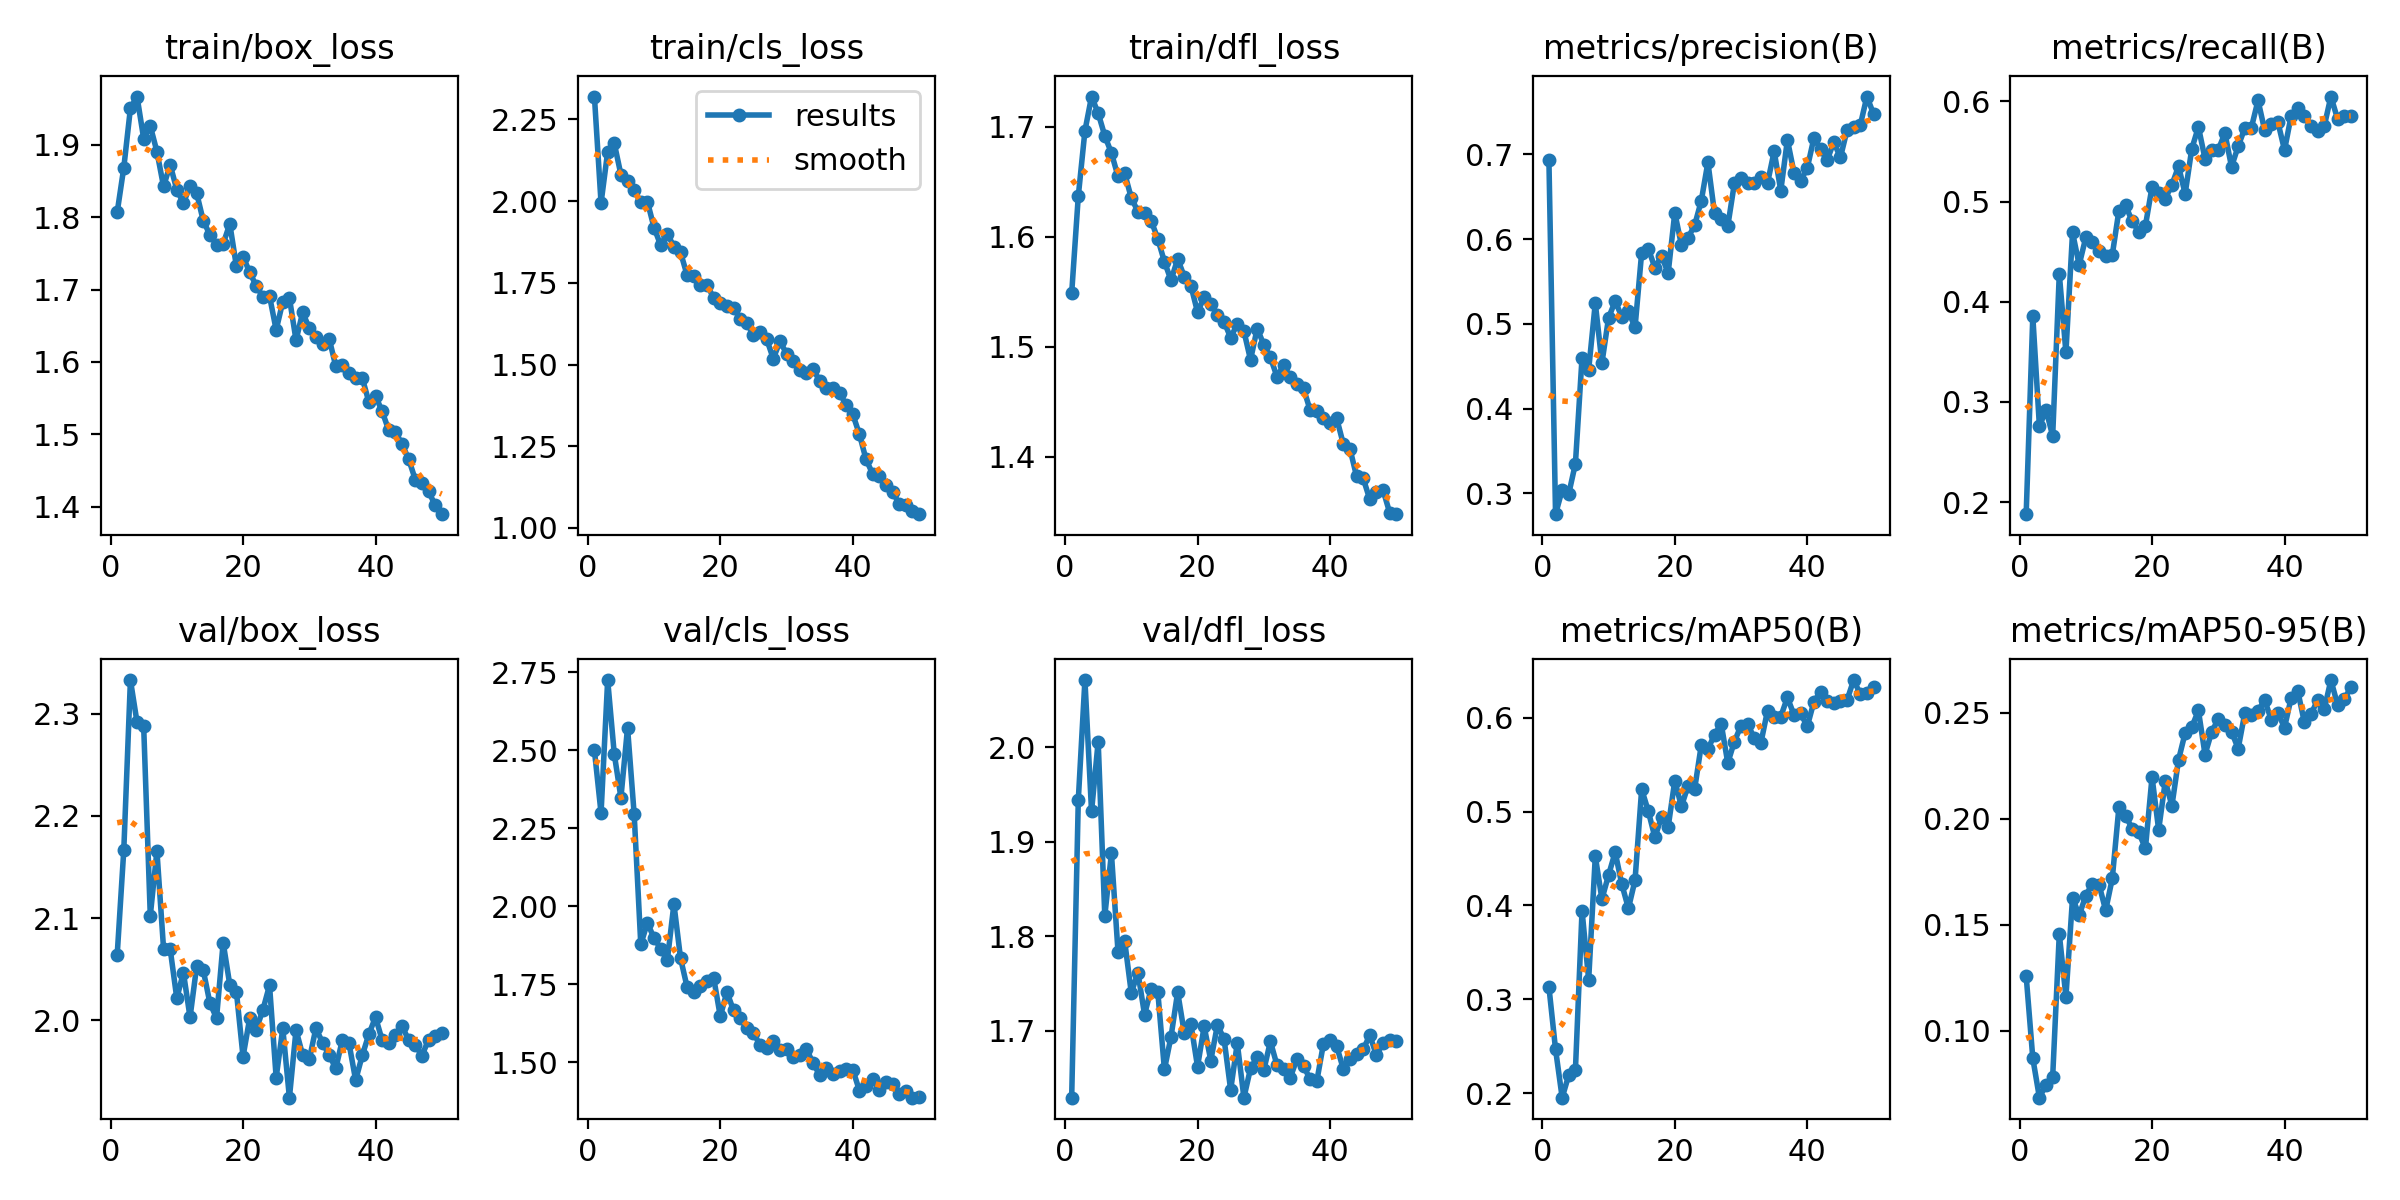


🎯 Confusion Matrix:


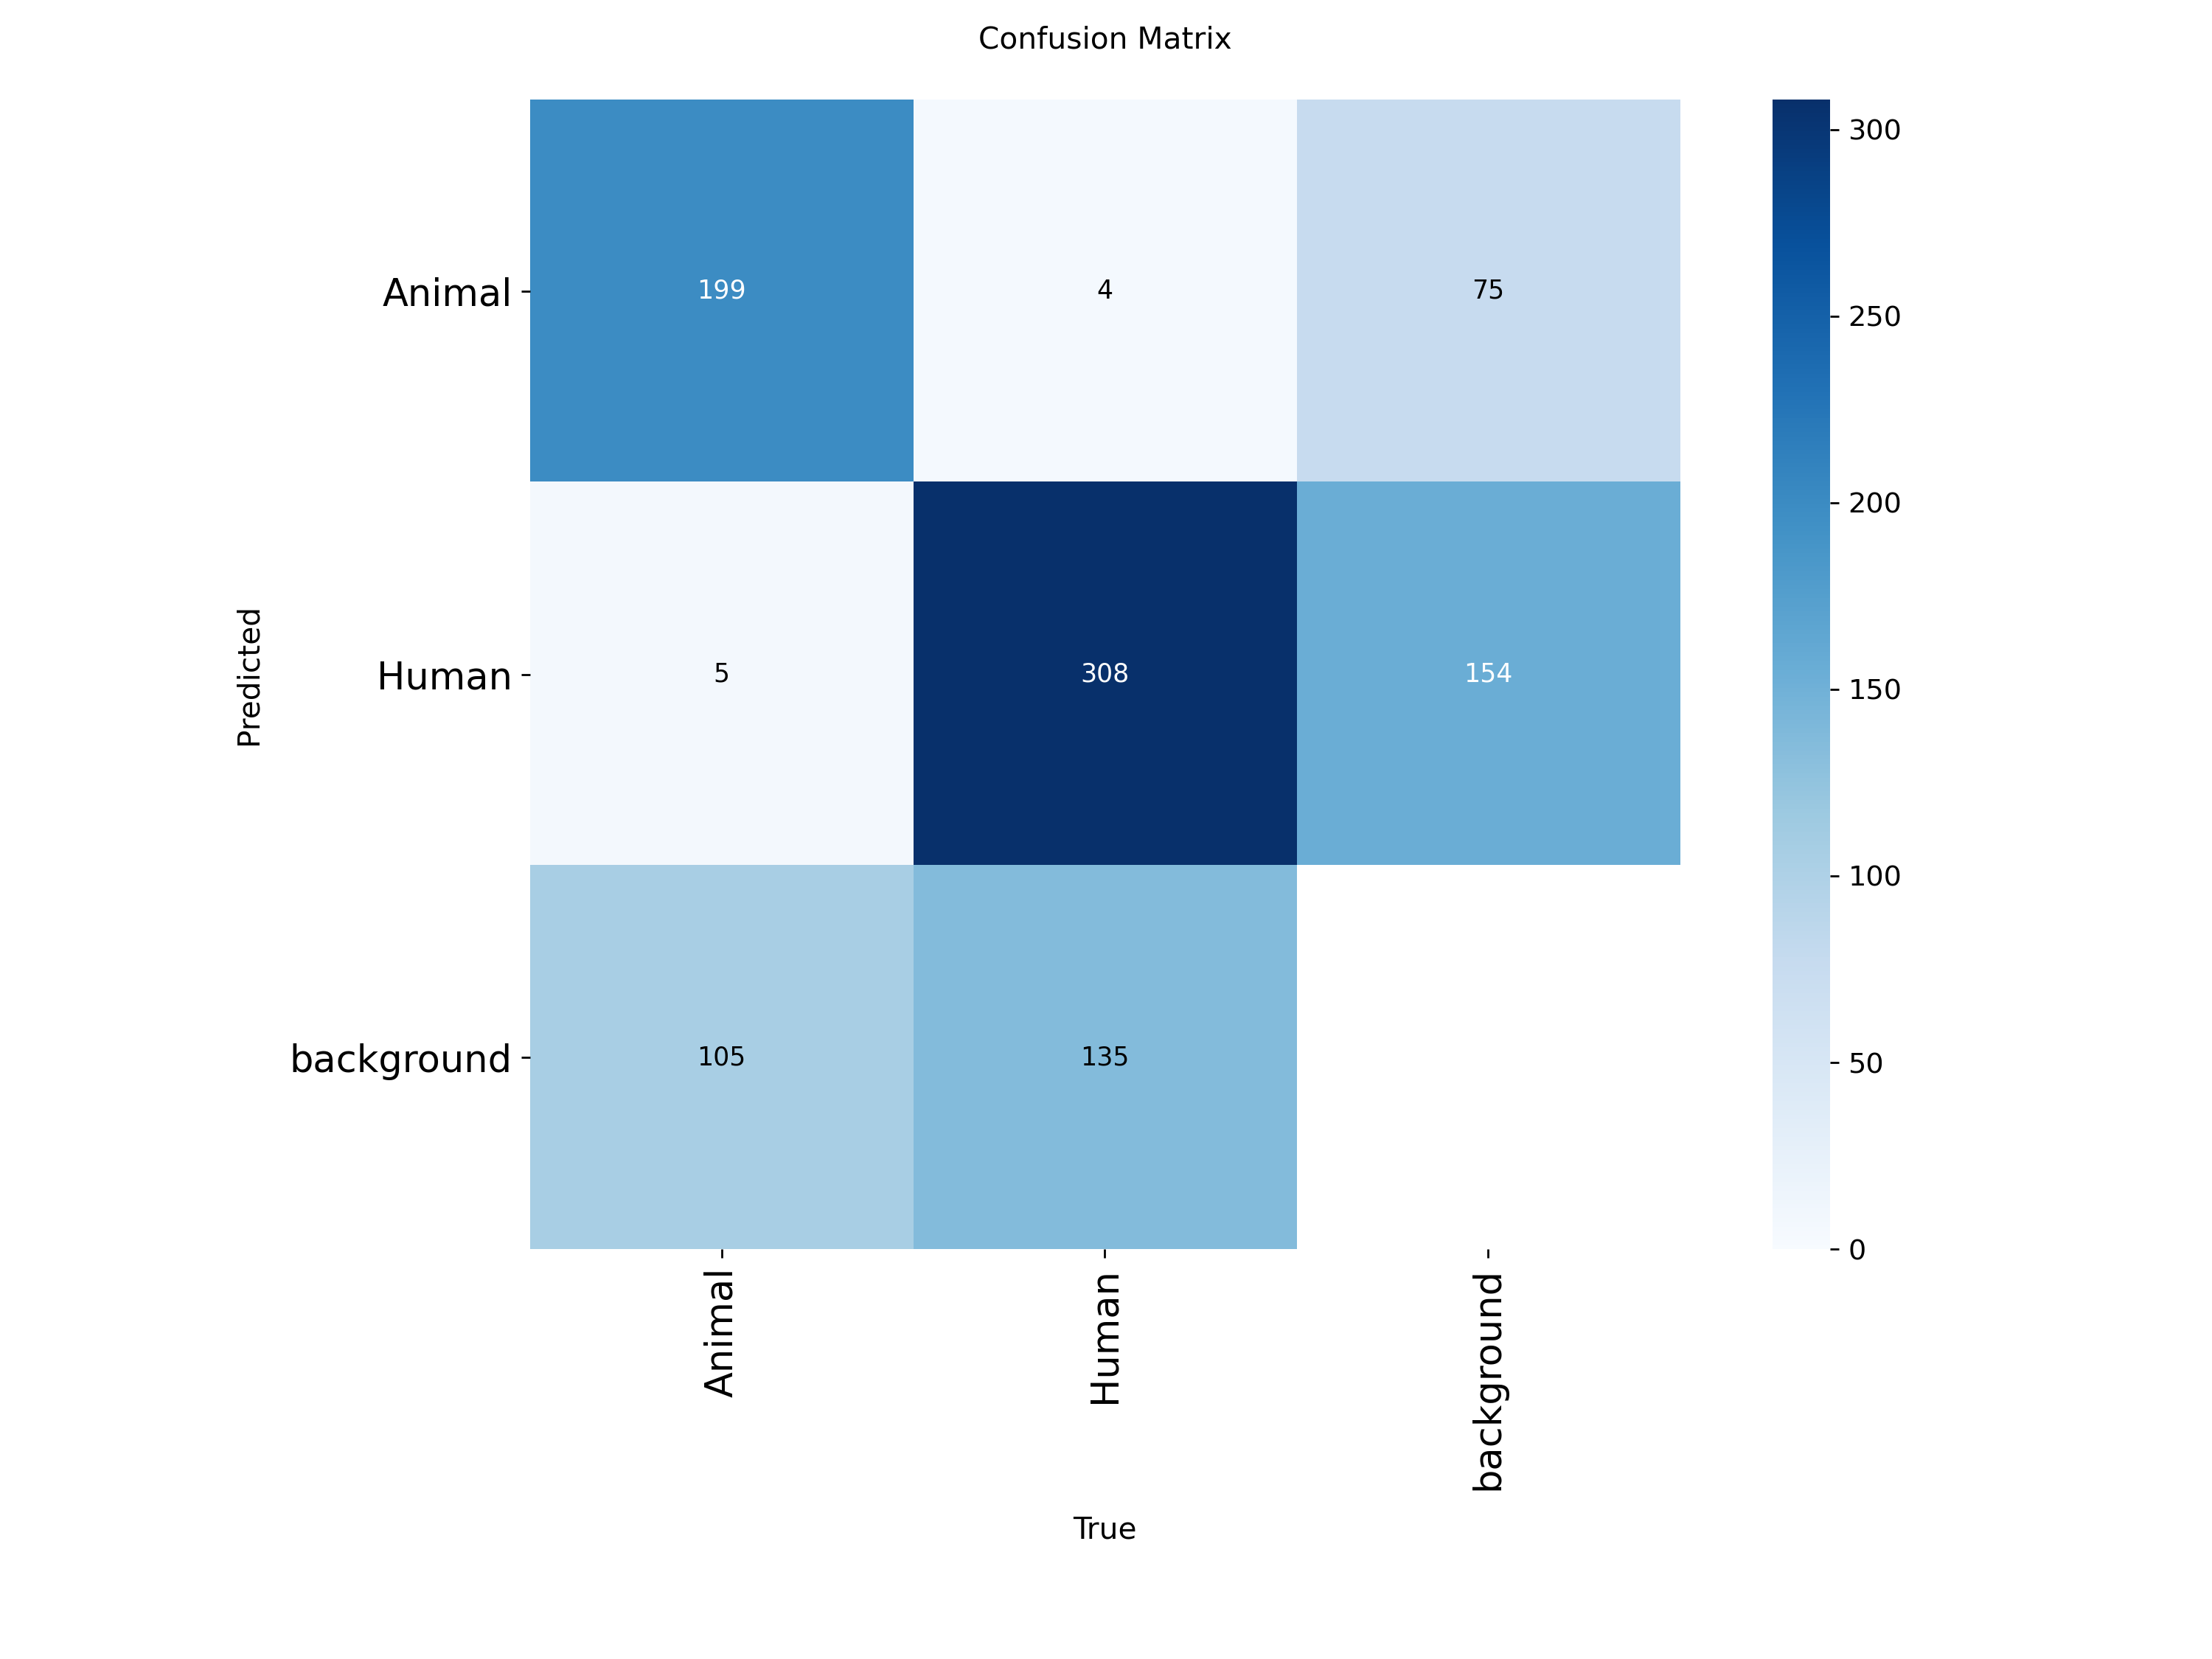


🔍 Sample Validation Predictions:


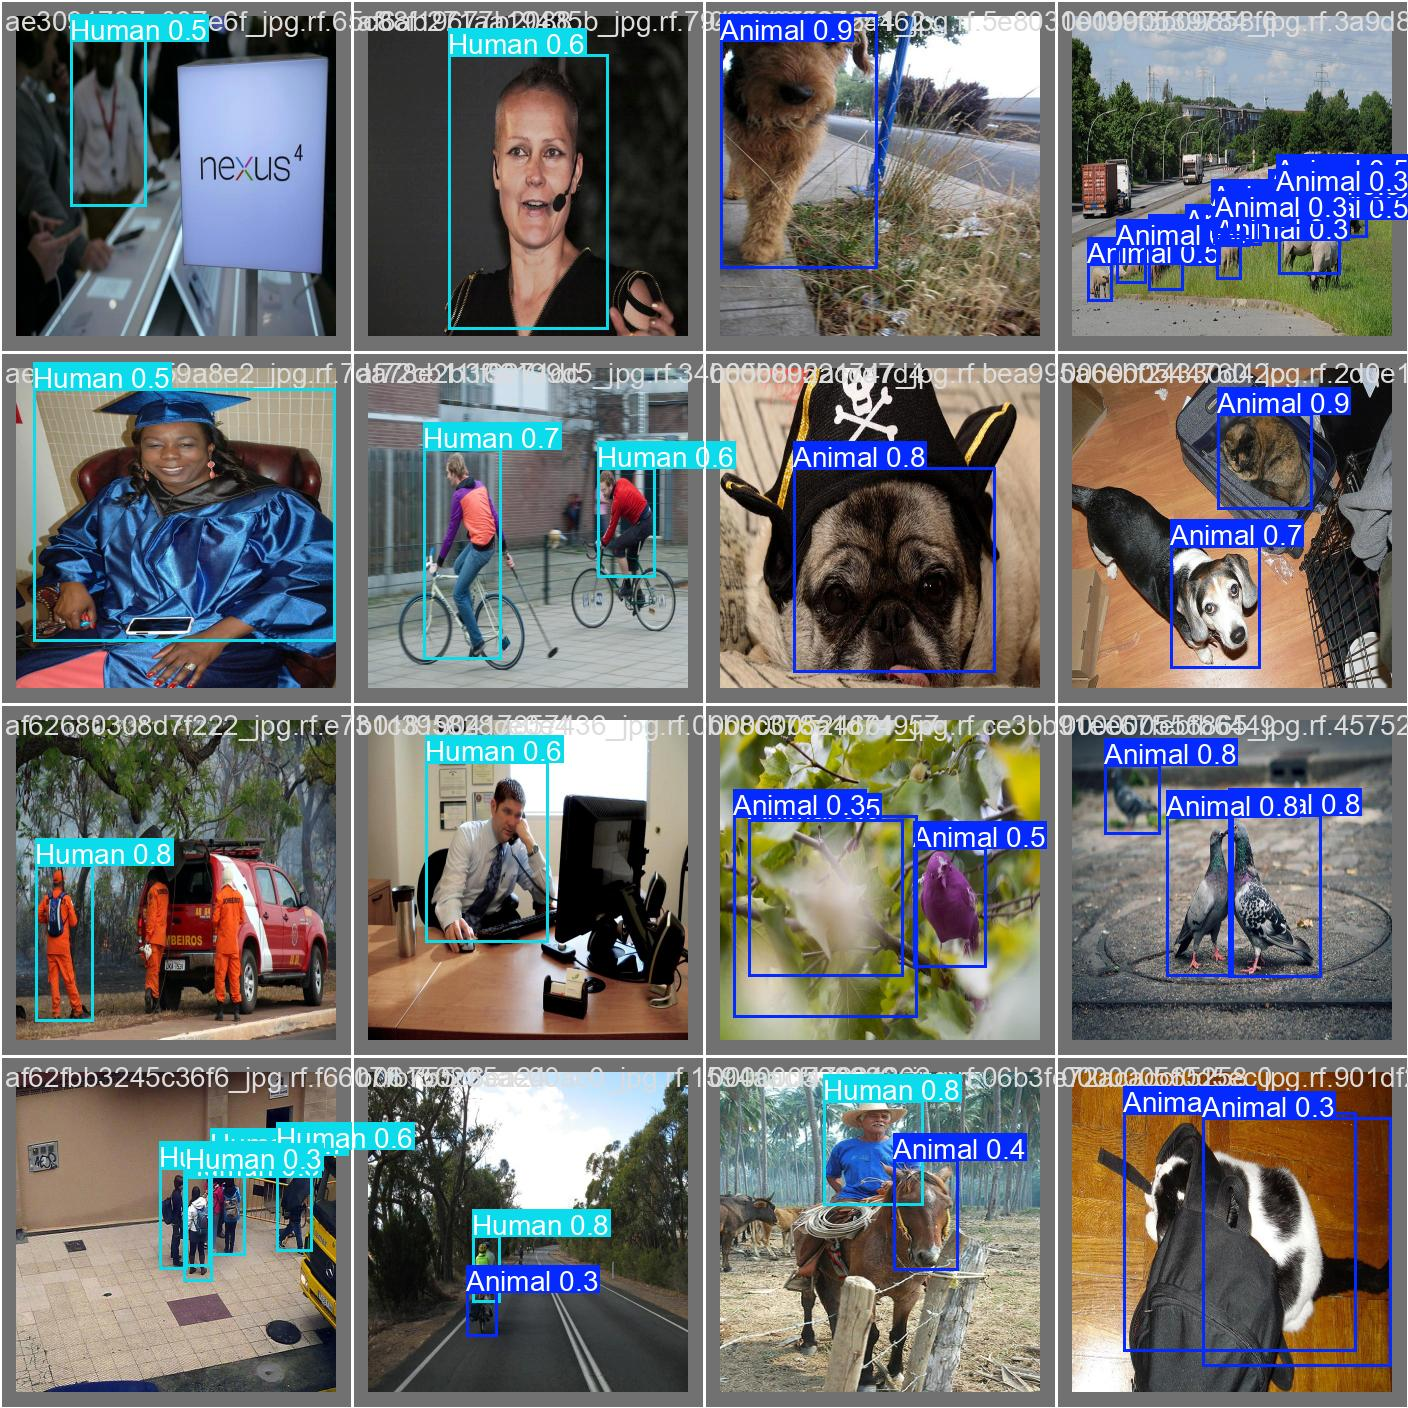


💡 All plots are saved in: runs/detect/raspberry_pi_model/


In [14]:
# Visualize training results and accuracy plots
from pathlib import Path
import matplotlib.pyplot as plt
from IPython.display import Image, display

results_dir = Path(MODELS_DIR) / 'raspberry_pi_model'

print("📊 Training Results Visualization:")
print("="*60)

# Show training curves
curves_file = results_dir / 'results.png'
if curves_file.exists():
    print("\n📈 Training Curves (Loss, mAP, Precision, Recall):")
    display(Image(str(curves_file)))
else:
    print("⚠️ Training curves not found")

# Show confusion matrix
confusion_file = results_dir / 'confusion_matrix.png'
if confusion_file.exists():
    print("\n🎯 Confusion Matrix:")
    display(Image(str(confusion_file)))

# Show validation predictions
val_batch_file = results_dir / 'val_batch0_pred.jpg'
if val_batch_file.exists():
    print("\n🔍 Sample Validation Predictions:")
    display(Image(str(val_batch_file)))

print("\n💡 All plots are saved in: runs/detect/raspberry_pi_model/")


In [ ]:
# Save trained model to Google Drive (PERSISTENT STORAGE)
# This ensures files are saved even if Colab session ends!

import shutil
import zipfile
from pathlib import Path

print("💾 Saving model to Google Drive...")
print("="*60)

# Check if Drive is already mounted, if not try to mount
# NOTE: Drive mounting doesn't work in Cursor Colab extension - use file browser instead
DRIVE_MOUNTED = False
drive_path = Path('/content/drive/MyDrive')

# Check if we're in Cursor (Drive won't work)
import os
IN_CURSOR = 'CURSOR' in os.environ or 'VSCODE' in os.environ

if IN_CURSOR:
    print("💡 Running in Cursor - Google Drive mounting not available")
    print("💡 Will create zip file for manual download instead")
    DRIVE_MOUNTED = False
elif drive_path.exists():
    DRIVE_MOUNTED = True
    print("✅ Google Drive already mounted!")
else:
    # Try to mount Google Drive (only works in Colab web)
    try:
        from google.colab import drive
        print("💾 Mounting Google Drive...")
        drive.mount('/content/drive')
        DRIVE_MOUNTED = True
        print("✅ Google Drive mounted successfully!")
    except Exception as e:
        print(f"⚠️ Could not mount Google Drive: {e}")
        DRIVE_MOUNTED = False
        print("💡 You can download files directly using Colab file browser")

if DRIVE_MOUNTED:
    # Create zip file of the entire model folder
    model_folder = Path(MODELS_DIR) / 'raspberry_pi_model'
    zip_path = Path('/content/raspberry_pi_model.zip')
    
    if model_folder.exists():
        # Create zip
        print("\n📦 Creating zip package...")
        shutil.make_archive(str(zip_path).replace('.zip', ''), 'zip', model_folder)
        zip_size = zip_path.stat().st_size / (1024*1024)
        print(f"✅ Zip created: {zip_size:.2f} MB")
        
        # Copy to Google Drive
        drive_models_dir = Path('/content/drive/MyDrive/SenseGrid_Models')
        drive_models_dir.mkdir(parents=True, exist_ok=True)
        
        # Copy zip to Drive
        drive_zip = drive_models_dir / 'raspberry_pi_model.zip'
        print(f"\n💾 Copying to Google Drive...")
        shutil.copy2(zip_path, drive_zip)
        print(f"✅ Saved to: {drive_zip}")
        
        # Also copy the entire model folder to Drive (for easy access)
        drive_model_folder = drive_models_dir / 'raspberry_pi_model'
        if drive_model_folder.exists():
            shutil.rmtree(drive_model_folder)
        print(f"\n📁 Copying model folder to Drive...")
        shutil.copytree(model_folder, drive_model_folder)
        print(f"✅ Model folder saved to: {drive_model_folder}")
        
        print("\n" + "="*60)
        print("✅ FILES SAVED TO GOOGLE DRIVE!")
        print("="*60)
        print(f"\n📍 Location in Google Drive:")
        print(f"   {drive_models_dir}")
        print(f"\n📦 Files saved:")
        print(f"   - raspberry_pi_model.zip ({zip_size:.2f} MB)")
        print(f"   - raspberry_pi_model/ (full folder)")
        print(f"\n💡 To download to your PC:")
        print(f"   1. Go to: https://drive.google.com")
        print(f"   2. Navigate to: My Drive > SenseGrid_Models")
        print(f"   3. Download raspberry_pi_model.zip")
        print(f"   4. Extract to: I:\\Web\\Academic\\SenseGrid\\models\\")
        
        # Also try to download directly (if in Colab web)
        try:
            from google.colab import files
            print(f"\n💡 Also downloading directly...")
            files.download(str(zip_path))
            print(f"✅ Direct download started!")
        except:
            print(f"💡 Use Google Drive to download (see instructions above)")
    else:
        print("⚠️ Model folder not found. Run training first!")
else:
    print("\n" + "="*60)
    print("⚠️ Google Drive not mounted - Using alternative method")
    print("="*60)
    
    # Create zip file anyway (for manual download)
    model_folder = Path(MODELS_DIR) / 'raspberry_pi_model'
    zip_path = Path('/content/raspberry_pi_model.zip')
    
    if model_folder.exists():
        print("\n📦 Creating zip package for manual download...")
        shutil.make_archive(str(zip_path).replace('.zip', ''), 'zip', model_folder)
        zip_size = zip_path.stat().st_size / (1024*1024)
        print(f"✅ Zip created: {zip_path}")
        print(f"📦 Size: {zip_size:.2f} MB")
        
        print("\n" + "="*60)
        print("💡 HOW TO DOWNLOAD YOUR FILES:")
        print("="*60)
        print("\nOption 1: Use Colab File Browser (Easiest)")
        print("   1. Click the folder icon (📁) in Colab's left sidebar")
        print("   2. Navigate to: /content/raspberry_pi_model.zip")
        print("   3. Right-click → Download")
        print("   4. Extract to: I:\\Web\\Academic\\SenseGrid\\models\\")
        
        print("\nOption 2: Try mounting Drive again")
        print("   - Run Cell 0 again to mount Drive")
        print("   - Then run this cell (Cell 8) again")
        
        print("\nOption 3: Direct download (try this first!)")
        try:
            from google.colab import files
            print("\n💡 Attempting direct download...")
            print("📥 This should work in Cursor - downloading now...")
            files.download(str(zip_path))
            print("✅ Download started!")
            print("💡 Check your browser's download folder for: raspberry_pi_model.zip")
        except Exception as e:
            print(f"\n⚠️ Direct download failed: {e}")
            print("\n💡 SOLUTION: Keep Cursor session running, open notebook in Colab web")
            print("   The files are on Colab VM - you can access them from web interface")
            print("   Steps:")
            print("   1. Keep this Cursor session running (don't terminate!)")
            print("   2. Open https://colab.research.google.com in a new tab")
            print("   3. Open the SAME notebook file (model.ipynb)")
            print("   4. It will connect to the SAME Colab runtime (files are there!)")
            print("   5. Use file browser to download")
            print("\n   OR: Wait until training is done, then download all files at once")
    else:
        print("⚠️ Model folder not found. Run training first!")

📦 Creating download package...
✅ Zip created: /content/raspberry_pi_model.zip
📦 Size: 59.55 MB

💡 Downloading...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✅ Download started!
📂 After download, extract to:
   I:\Web\Academic\SenseGrid\models\


✅ Copied to: /path/to/your/SenseGrid/models/raspberry_pi_model.zip
📦 Size: 59.55 MB

💡 Extract the zip to: /path/to/your/SenseGrid/models


In [20]:
# For Cursor Colab Extension: Files are on Colab VM, need manual download
# This cell shows you where files are and how to get them

from pathlib import Path
import os

print("="*60)
print("📦 FILE LOCATION GUIDE FOR CURSOR COLAB EXTENSION")
print("="*60)

# Check where files are on Colab VM
colab_zip = Path('/content/raspberry_pi_model.zip')
colab_model_dir = Path('/content/SenseGrid_Project/models/raspberry_pi_model')

print("\n📍 Files are on Colab VM (not your local PC yet):")
print(f"   Zip file: {colab_zip}")
print(f"   Model folder: {colab_model_dir}")

if colab_zip.exists():
    size_mb = colab_zip.stat().st_size / (1024 * 1024)
    print(f"\n✅ Zip file found: {size_mb:.2f} MB")
    
    # List what's in the model folder
    if colab_model_dir.exists():
        weights_dir = colab_model_dir / 'weights'
        if weights_dir.exists():
            print(f"\n📁 Model files available:")
            for file in weights_dir.glob('*'):
                if file.is_file():
                    size = file.stat().st_size / (1024 * 1024)
                    print(f"   - {file.name}: {size:.2f} MB")
    
    print("\n" + "="*60)
    print("💡 HOW TO GET FILES TO YOUR PC:")
    print("="*60)
    print("\nOption 1: Use Cursor's File Explorer")
    print("   1. In Cursor, open the file explorer (left sidebar)")
    print("   2. Look for 'Colab Files' or remote file browser")
    print("   3. Navigate to: /content/raspberry_pi_model.zip")
    print("   4. Right-click → Download or drag to local folder")
    print("\nOption 2: Use Colab Web Interface")
    print("   1. Open the same notebook in Google Colab web")
    print("   2. Use the file browser (left sidebar)")
    print("   3. Navigate to: /content/raspberry_pi_model.zip")
    print("   4. Right-click → Download")
    print("\nOption 3: Copy files manually")
    print("   Run the next cell to copy files to a location you can access")
    
else:
    print("\n⚠️ Zip file not found. Run Cell 8 first to create it!")

📦 FILE LOCATION GUIDE FOR CURSOR COLAB EXTENSION

📍 Files are on Colab VM (not your local PC yet):
   Zip file: /content/raspberry_pi_model.zip
   Model folder: /content/SenseGrid_Project/models/raspberry_pi_model

✅ Zip file found: 59.55 MB

📁 Model files available:
   - last.pt: 5.92 MB
   - best.onnx: 11.63 MB
   - best.pt: 5.92 MB

💡 HOW TO GET FILES TO YOUR PC:

Option 1: Use Cursor's File Explorer
   1. In Cursor, open the file explorer (left sidebar)
   2. Look for 'Colab Files' or remote file browser
   3. Navigate to: /content/raspberry_pi_model.zip
   4. Right-click → Download or drag to local folder

Option 2: Use Colab Web Interface
   1. Open the same notebook in Google Colab web
   2. Use the file browser (left sidebar)
   3. Navigate to: /content/raspberry_pi_model.zip
   4. Right-click → Download

Option 3: Copy files manually
   Run the next cell to copy files to a location you can access


In [ ]:
# Create a local download script (run this on your PC, not in Colab)
# This will be saved to your project folder

download_script = '''
# download_model_from_colab.py
# Run this script on your LOCAL PC (not in Colab) to download files

import os
from pathlib import Path

print("="*60)
print("📥 DOWNLOAD MODEL FROM COLAB")
print("="*60)
print("\\n⚠️  This script needs to be run from Google Colab web interface")
print("\\n💡 Instructions:")
print("   1. Open this notebook in Google Colab web (colab.research.google.com)")
print("   2. Run Cell 8 to create the zip file")
print("   3. In Colab's file browser (left sidebar), find:")
print("      /content/raspberry_pi_model.zip")
print("   4. Right-click → Download")
print("   5. Extract to: I:\\\\Web\\\\Academic\\\\SenseGrid\\\\models\\\\")
print("\\n✅ After extraction, your files will be at:")
print("   I:\\\\Web\\\\Academic\\\\SenseGrid\\\\models\\\\raspberry_pi_model\\\\weights\\\\")
print("   - best.pt")
print("   - best.tflite")
'''

# Save script to project root
script_path = Path('download_model_from_colab.py')
script_path.write_text(download_script)
print(f"✅ Created helper script: {script_path}")
print("💡 This script contains instructions for downloading")


In [18]:
from pathlib import Path
zip_path = Path('/content/raspberry_pi_model.zip')
if zip_path.exists():
    size_mb = zip_path.stat().st_size / (1024 * 1024)
    print(f"✅ Zip found: {zip_path}")
    print(f"📦 Size: {size_mb:.2f} MB")
else:
    print("⚠️ Zip not found at that location")

✅ Zip found: /content/raspberry_pi_model.zip
📦 Size: 59.55 MB


## 📥 Models Location

After training completes, models are saved in your project folder:

1. **best.pt** - PyTorch model (for testing/development)
2. **best.tflite** - TensorFlow Lite model (for Raspberry Pi deployment)

### Location:
- **Project Folder**: `{PROJECT_PATH}/models/raspberry_pi_model/weights/`
- **For Deployment**: Models are also copied to `backend/models/` (if running locally)

### For Raspberry Pi:
- Use **best.tflite** (TensorFlow Lite format)
- Install: `pip install tflite-runtime` on Raspberry Pi
- Model size: ~2-4 MB (very lightweight!)
- Inference speed: ~50-200ms per image (depending on Pi model)
- Copy `best.tflite` to `backend/models/` on your Raspberry Pi

### Training Summary:
- **Training Time**: ~2-2.5 hours (improved for better accuracy)
- **Model Architecture**: YOLOv8n (Nano)
- **Image Size**: 416x416 (sweet spot for Pi - better accuracy, still fast)
- **Format**: TensorFlow Lite with INT8 quantization
- **Target Accuracy**: 75-80% mAP50 (up from 64%)
- **Pi Performance**: ~12-14 FPS (still very usable for security)
- **Storage**: Saved directly to your project folder (not temporary!)


## 📂 Project Folder Structure

**All files are saved to your project folder (not temporary storage!)**

### What's Saved:
1. ✅ **Dataset** - Saved in `{PROJECT_PATH}/datasets/intruder_batch1_v9/`
2. ✅ **Trained Models** - `best.pt` and `best.tflite` in `models/raspberry_pi_model/weights/`
3. ✅ **Training Results** - CSV, plots, confusion matrix, validation images
4. ✅ **All Training Artifacts** - Everything needed to resume or analyze later

### Project Structure:
```
SenseGrid/
├── models/
│   └── raspberry_pi_model/
│       ├── weights/
│       │   ├── best.pt
│       │   └── best.tflite
│       ├── results.csv
│       ├── results.png
│       └── confusion_matrix.png
├── datasets/
│   └── intruder_batch1_v9/
│       ├── data.yaml
│       ├── train/
│       ├── valid/
│       └── test/
└── backend/
    └── models/  (models copied here for deployment)
```

### If Running in Colab:
- Files are saved in `/content/SenseGrid_Project/`
- Download the entire folder to your PC
- Extract to your SenseGrid project root
- Models will be in the correct location!


In [ ]:
# List all model files and show summary
import os
from pathlib import Path

model_dir = Path(MODELS_DIR) / 'raspberry_pi_model' / 'weights'
results_dir = Path(MODELS_DIR) / 'raspberry_pi_model'

print("="*60)
print("📦 MODEL FILES SUMMARY")
print("="*60)

if model_dir.exists():
    print("\n✅ Available model files:")
    total_size = 0
    for file in sorted(model_dir.glob('*')):
        size_mb = file.stat().st_size / (1024 * 1024)
        total_size += size_mb
        file_type = "🎯 TFLite (for Pi)" if file.suffix == '.tflite' else "🔧 PyTorch"
        print(f"   {file_type} - {file.name}: {size_mb:.2f} MB")
    
    print(f"\n📊 Total size: {total_size:.2f} MB")
    
    if IN_COLAB:
        print("\n💡 To download to your PC:")
        print(f"   1. In Colab file browser, go to: {MODELS_DIR}")
        print("   2. Right-click 'raspberry_pi_model' folder")
        print("   3. Select 'Download'")
        print("   4. Extract to your SenseGrid project folder")
    else:
        print(f"\n✅ Models are already in your project folder!")
        print(f"   Location: {model_dir}")
        print(f"   For Raspberry Pi, use: {model_dir / 'best.tflite'}")
    
    # Check if results exist
    if results_dir.exists():
        print("\n📈 Additional files available:")
        if (results_dir / 'results.csv').exists():
            print("   - results.csv (training history)")
        if (results_dir / 'results.png').exists():
            print("   - results.png (training curves)")
        if (results_dir / 'confusion_matrix.png').exists():
            print("   - confusion_matrix.png (accuracy matrix)")
else:
    print("⚠️ Model directory not found. Run training cells first.")
    print(f"   Expected location: {model_dir}")


## ⚡ GPU Usage & File Storage - Important Notes

### GPU Usage is NOT Affected by File Paths!

**Key Points:**
1. ✅ **GPU works normally** - Controlled by `device=0` parameter, not file paths
2. ✅ **Training happens on Colab's GPU** - Files are just saved to Colab's storage (`/content/`)
3. ✅ **File paths only affect storage location** - They don't impact computation
4. ✅ **After training, download files** - Then copy to your PC project folder

### How It Works:

**In Colab:**
- 🖥️ **Computation**: Happens on Colab's GPU (fast!)
- 💾 **Storage**: Files saved to `/content/SenseGrid_Project/` (Colab's VM)
- 📥 **Download**: After training, download folder to your PC

**On Your PC:**
- 🖥️ **Computation**: Uses your local GPU/CPU
- 💾 **Storage**: Files saved directly to your project folder
- ✅ **No download needed**: Files are already in the right place

### GPU Verification:
The training cell checks GPU availability automatically. If GPU is detected, you'll see:
```
✅ GPU Available: Tesla T4 (or similar)
💪 GPU Memory: 15.0 GB
```

If no GPU, training will use CPU (much slower but still works).


In [ ]:
# QUICK DOWNLOAD - Use this cell to download files directly
# This works even if Drive mounting failed
# Run this cell to download the zip file to your PC

import shutil
from pathlib import Path

print("📥 QUICK DOWNLOAD - Direct file download")
print("="*60)

# Create zip if it doesn't exist
model_folder = Path(MODELS_DIR) / 'raspberry_pi_model'
zip_path = Path('/content/raspberry_pi_model.zip')

if not zip_path.exists() and model_folder.exists():
    print("📦 Creating zip file...")
    shutil.make_archive(str(zip_path).replace('.zip', ''), 'zip', model_folder)
    print("✅ Zip created!")

if zip_path.exists():
    size_mb = zip_path.stat().st_size / (1024*1024)
    print(f"\n✅ Zip file ready: {size_mb:.2f} MB")
    print(f"📍 Location: {zip_path}")
    
    # Try direct download
    try:
        from google.colab import files
        print("\n📥 Downloading directly to your PC...")
        files.download(str(zip_path))
        print("\n✅ Download started!")
        print("💡 Check your browser's Downloads folder")
        print("💡 File name: raspberry_pi_model.zip")
        print(f"💡 Size: {size_mb:.2f} MB")
        print("\n📂 After download, extract to:")
        print("   I:\\Web\\Academic\\SenseGrid\\models\\")
    except Exception as e:
        print(f"\n⚠️ Direct download not available: {e}")
        print("\n" + "="*60)
        print("💡 ALTERNATIVE: Access files from Colab web")
        print("="*60)
        print("\nYou can access files WITHOUT terminating this session:")
        print("   1. Keep this Cursor session running")
        print("   2. Open https://colab.research.google.com in browser")
        print("   3. Upload/open your model.ipynb file")
        print("   4. Colab will connect to the SAME runtime (files are there!)")
        print("   5. Use Colab's file browser to download")
        print("\n   The files are on Colab's VM, not in Cursor - so web can access them!")
else:
    print("⚠️ Zip file not found. Run Cell 8 first to create it!")
